In [2]:
import sys
sys.path.append('../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.environment_converter import minimal_converter
from olfactory_navigation.test_setups import run_all_starts_test
from olfactory_navigation.agents.model_based_util.pomdp import Model

In [3]:
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [4]:
indices = np.arange(101)
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal([50, 50], 200)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

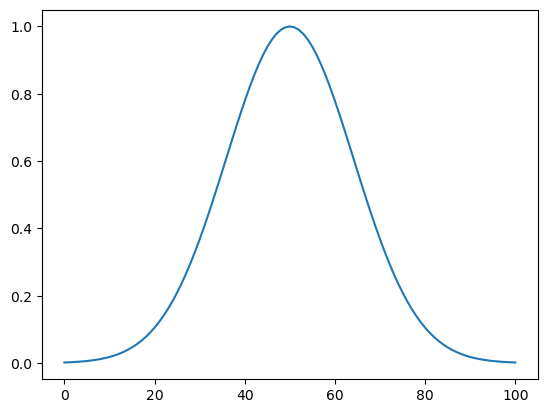

In [5]:
plt.plot(probability_map[50])

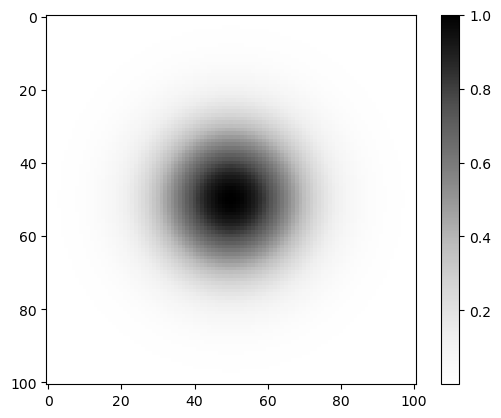

In [6]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

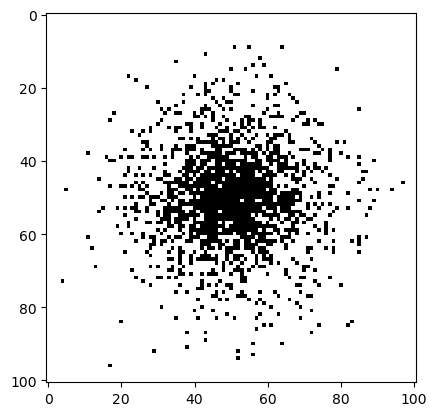

In [7]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

# Print sample
plt.imshow(multiple_samples[4], cmap='Greys')

## Model Definition

### Basic cell and states

In [8]:
# Cell definition
cells = [9,9]
# cells = 9

if isinstance(cells, int):
    cells = np.ones(2) * cells
else:
    cells = np.array(cells)

In [9]:
assert np.all((cells % 2) == 1), "Amount of cells need to be odd in both directions"

In [10]:
spacial_cell_count = int(cells.prod()) # How many physical cells we consider
cell_count = int(spacial_cell_count ** 2) # Square of the produce as we need the same size in both the agent state layer and the source state layer 
print(f'{spacial_cell_count = }')
print(f'{cell_count = }')

spacial_cell_count = 81
cell_count = 6561


In [11]:
combined_shape = (
    *cells, # First 2 dims: Source position
    *cells  # Last 2 dims: Agent position
)

print(f'{combined_shape = }')

combined_shape = (9, 9, 9, 9)


In [12]:
cell_ids = np.arange(cell_count).reshape(combined_shape)

# To find out agent position: cell[i,j] % spacial_cell_count

In [13]:
# Get the list of all indices
indices_list = list(np.ndindex(cell_ids.shape))

# Print the indices list
state_labels = [f's_{s_y}_{s_x}-a_{a_y}_{a_x}' for (s_y, s_x, a_y, a_x) in indices_list] + ['goal']
state_labels[:10]
# Add goal states or state?
# state_labels += []

['s_0_0-a_0_0',
 's_0_0-a_0_1',
 's_0_0-a_0_2',
 's_0_0-a_0_3',
 's_0_0-a_0_4',
 's_0_0-a_0_5',
 's_0_0-a_0_6',
 's_0_0-a_0_7',
 's_0_0-a_0_8',
 's_0_0-a_1_0']

### Cell space mapping

In [14]:
space_shape = probability_map.shape
print(f'{space_shape = }')

space_shape = (101, 101)


In [15]:
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

In [16]:
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

cell_sizes = []
for ax_count, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    ax_cell_sizes = np.full(ax_count, ax_size)
    ax_cell_sizes[0] += np.floor(ax_overflow / 2)
    ax_cell_sizes[-1] += np.ceil(ax_overflow / 2)
    cell_sizes.append(ax_cell_sizes)

In [17]:
# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

grid_cells = np.full(space_shape, -1)
for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]
    
    # Grid to cell mapping
    grid_cells[*slices] = i

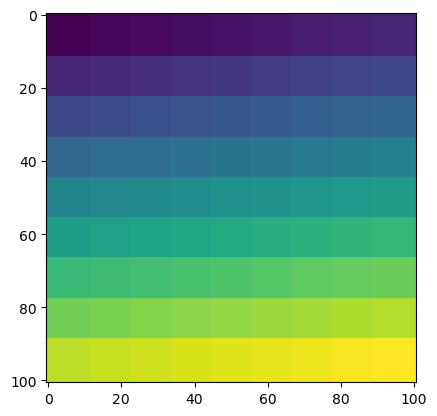

In [18]:
plt.imshow(grid_cells)

### Actions

In [19]:
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

### Observations

In [20]:
threshold = 3e-6

# Compute observation matrix
if not isinstance(threshold, list):
    threshold = [threshold]

# Ensure 0.0 and 1.0 begin and end the threshold list
if threshold[0] != -np.inf:
    threshold = [-np.inf] + threshold

if threshold[-1] != np.inf:
    threshold = threshold + [np.inf]

In [21]:
#  Observation labels
observation_labels = ['nothing']
if len(threshold) > 3:
    for i,_ in enumerate(threshold[1:-1]):
        observation_labels.append(f'something_l{i}')
else:
    observation_labels.append('something')
observation_labels.append('goal')

In [22]:
cell_probabilities = np.full(cells, -1, dtype=float)
for cell, lower_b, upper_b in zip(list(np.ndindex(tuple(cells))), lower_bounds, upper_bounds):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # TODO: Make it flexible to multi thresh
    cell_probabilities[*cell] = np.average(multiple_samples[:,*slices].astype(float))

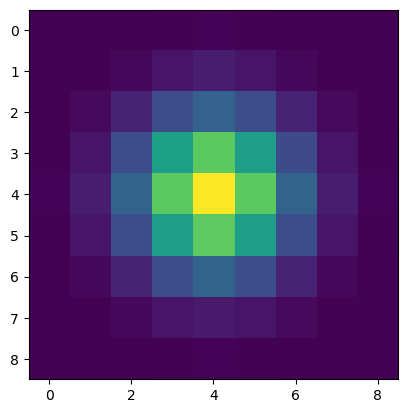

In [23]:
plt.imshow(cell_probabilities)

In [24]:
odor_probabilities = np.zeros(combined_shape)
center_pos = (cells / 2).astype(int)
all_positions = list(np.ndindex(tuple(cells)))
for source_pos in all_positions:
    for agent_pos in all_positions:
        relative_position = (np.array(agent_pos) - np.array(source_pos)) + center_pos
        if np.any(relative_position < 0) or np.any(relative_position >= cells):
            continue
        odor_probabilities[*source_pos, *agent_pos] = cell_probabilities[*relative_position]

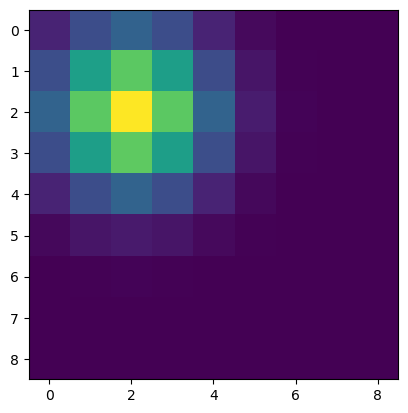

In [25]:
plt.imshow(odor_probabilities[2,2])

In [26]:
observations = np.zeros((cell_count+1, len(action_set), len(observation_labels)))

In [27]:
observations[:-1,:,0] = 1 - odor_probabilities[*np.array(indices_list).T][:,None]
observations[:-1,:,1] = odor_probabilities[*np.array(indices_list).T][:,None]

observations[-1,:,0] = 0.0
observations[:,:,-1] = 0.0
observations[-1,:,-1] = 1.0 # Goal

### Transitions

In [28]:
points = np.array(list(np.ndindex(tuple(space_shape))))

In [29]:
boundary_condition = 'stop'
movements_new_points = []

for movement in action_set:
    # Applying the movement vector
    new_pos = points + movement

    # Handling the case we are dealing with a single point.
    is_single_point = (len(pos.shape) == 1)
    if is_single_point:
        new_pos = new_pos[None,:]

    shape_array = np.array(space_shape)[None,:]

    # Wrap boundary
    if boundary_condition == 'wrap':
        new_pos = np.where(new_pos < 0, (new_pos + shape_array), new_pos)
        new_pos = np.where(new_pos >= shape_array, (new_pos - shape_array), new_pos)

    # Stop boundary
    elif boundary_condition == 'stop':
        new_pos = np.clip(new_pos, 0, (shape_array-1))

    movements_new_points.append(new_pos)

In [30]:
# cell_transition_probabilities = np.full((spacial_cell_count, len(action_set), spacial_cell_count), -1, dtype=float)

# for a, new_points in enumerate(movements_new_points):
#     for start_id in range(spacial_cell_count):
#         in_start_cell = (grid_cells[*np.array(points).T] == start_id)

#         for end_id in range(spacial_cell_count):
#             in_end_cell = (grid_cells[*np.array(new_points).T] == end_id)

#             cell_transition_probabilities[start_id,a,end_id] = np.sum((in_start_cell & in_end_cell)) / np.sum(in_start_cell)

In [31]:
# cell_transition_probabilities[12,3,:].reshape(cells)

In [32]:
transition_probabilities = np.full((cell_count+1, len(action_set), cell_count+1), -1, dtype=float)

spacial_cell_ids = cell_ids[0,0]
points_array = np.array(indices_list)

cell_centers = ((lower_bounds + upper_bounds) / 2).astype(int)
source_radius = 2

movements_new_points_array = np.array(movements_new_points)

for start_id, start_point in enumerate(indices_list):

    start_source_point = start_point[:2]
    start_source_id = spacial_cell_ids[*start_source_point]

    start_agent_point = start_point[2:]
    start_agent_id = spacial_cell_ids[*start_agent_point]


    # All other destination states have probability 0
    transition_probabilities[start_id,:,:-1] = 0.0

    # Filtering to the same source state set
    equal_end_states = np.all(points_array[:,:2] == start_source_point , axis=1)
    next_cell_ids = np.arange(cell_count)[equal_end_states]
    next_points_array = points_array[equal_end_states,2:]

    # Determine the position of the source in the source_cell
    source_position = cell_centers[start_source_id]

    # determine points in agent's starting cell
    in_start_cell = (grid_cells[*np.array(points).T] == start_agent_id)
    in_start_cell_count = np.sum(in_start_cell).astype(float)

    # determine next agent cell ids
    next_agent_id = spacial_cell_ids[*next_points_array.T]

    # determine points in agent's end cell
    in_end_cell = (grid_cells[*movements_new_points_array.T, None] == next_agent_id[None,None,:]) # |P| x |A| x |CELLS|

    # determine points that reached the source
    at_source = (((movements_new_points_array.T - source_position[:,None,None])**2).sum(axis=0) <= (source_radius**2))

    # Computing probabilities
    transition_probabilities[start_id,:,next_cell_ids] = np.sum(in_start_cell[:,None,None] & in_end_cell & (~at_source[:,:,None]), axis=0).astype(float).T / in_start_cell_count
    transition_probabilities[start_id,:,-1] = np.sum(in_start_cell[:,None] & at_source[:,:], axis=0).astype(float) / in_start_cell_count

transition_probabilities[-1,:,:] = 0.0
transition_probabilities[-1,:,-1] = 1.0

assert np.all(np.sum(transition_probabilities, axis=2).round(10) == 1.0), "Some transitions dont sum to 1"

# transition_probabilities /= np.sum(transition_probabilities, axis=2)[:,:,None]

In [33]:
# Simple test (sanity check)
source_center_state = (spacial_cell_count * int(spacial_cell_count / 2))
center_cell = source_center_state + int(spacial_cell_count / 2)
print(transition_probabilities[center_cell,0,source_center_state:source_center_state+spacial_cell_count].reshape(cells).round(3))
print(f'Goal prob: {transition_probabilities[3280,0,-1]:.3f}')

[[0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.091 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.802 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.   ]]
Goal prob: 0.107


### Model

In [34]:
model = Model(
    states = state_labels,
    actions = action_labels,
    observations = observation_labels,
    transitions = transition_probabilities,
    observation_table = observations,
    end_states = [cell_count], # The very last state is the goal state
    # start_probabilities = start_probabilities,
    seed=12131415
)

## Training agent

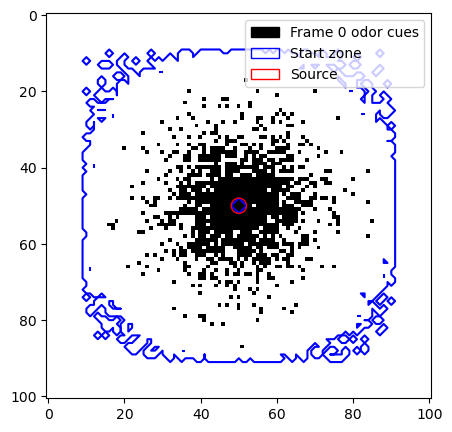

In [35]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              margins=[10,10],
                              boundary_condition='stop',
                              start_zone='odor_present',
                              odor_present_threshold=3e-1)

artificial_env.plot()

In [36]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-8,
                model=model)

In [37]:
_ = ag.train(expansions=300, use_gpu=True)

[07/30/2024, 16:24:01] MDP_policy, not provided. Solving MDP with Value Iteration...
[07/30/2024, 16:24:01] Sending Model to GPU...
[07/30/2024, 16:24:02]     > Done in 0.863s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 6562-state, 4-action
  - Converged in 918 iterations and 1.2826 seconds
  - Took on average 0.0014s per iteration


Expansions:   0%|          | 0/300 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 6562 state, 4 action, 3 observations
  - Converged or stopped after 300 expansion steps and 300 backup steps.
  - Resulting value function has 1480 alpha vectors.
  - Converged in 11.2104s

  - Expand function took on average 0.0104s and yielded on average 330.91 beliefs per iteration. (0.0001s/it/belief)
  - Backup function took on average 0.0269s and yielded on average 4.93 alpha vectors per iteration. (0.0000s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


## Testing agent

In [38]:
from olfactory_navigation.simulation import run_test
from olfactory_navigation.agents.model_based_util.belief import Belief, BeliefSet

In [39]:
# data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

# source_position = (np.array([15,15]) / 0.8).astype(int)
# tank_size = (np.array([90,110]) / 0.8).astype(int)

# env = Environment(data_file=data,
#                   data_source_position=[66, 66],
#                   source_radius=2,
#                   layers=False,
#                   shape=[101,101],
#                   margins=0,
#                   boundary_condition='wrap_vertical',
#                   start_zone='odor_present',
#                   odor_present_threshold=3e-6)

# env.plot(frame=500)

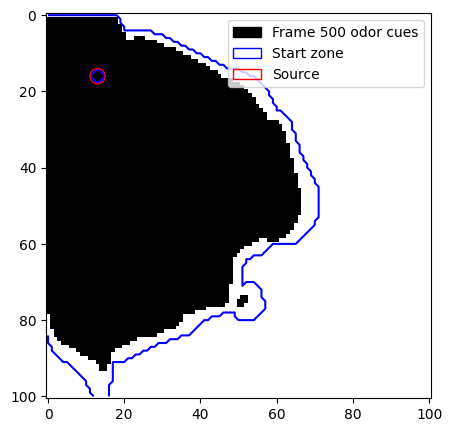

In [40]:
import h5py
data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

loaded_data = h5py.File(data_path,'r')
data = np.array([loaded_data['odor_base'][timeslice] for timeslice in loaded_data['odor_base']])

env = Environment(data_file=data,
                  data_source_position=[66, 66],
                  source_radius=2,
                  layers=False,
                  shape=[101,101],
                  margins=0,
                  boundary_condition='stop',
                  start_zone='odor_present',
                  odor_present_threshold=3e-10)

env.plot(frame=500)

In [40]:
# REPLACING WITH ARTIFICAL DATA !!
env = artificial_env
# !! Remove me

In [41]:
# Taking all starting points
start_points = np.argwhere(env.start_probabilities > 0)
n = len(start_points)

In [42]:
# From the starting points, gather what cell they came from
cell_indices_array = np.array(indices_list)
start_points_cell_ids = grid_cells[*start_points.T]
start_points_cells = cell_indices_array[:spacial_cell_count][start_points_cell_ids,2:]

In [43]:
beliefs = []

for cell in start_points_cells:
    all_source_states = np.argwhere(np.all(cell_indices_array[:,2:] == cell, axis=1))[:,0]

    # Defining start probabilities
    start_prob = np.zeros(cell_count+1, dtype=float)
    start_prob[all_source_states] = 1.0
    start_prob /= np.sum(start_prob)

    # Building belief point
    belief_point = Belief(model=model, values=start_prob)
    beliefs.append(belief_point)

all_beliefs = BeliefSet(model, beliefs)

In [52]:
np.where(beliefs[0].values)[0]

array([   1,   82,  163,  244,  325,  406,  487,  568,  649,  730,  811,
        892,  973, 1054, 1135, 1216, 1297, 1378, 1459, 1540, 1621, 1702,
       1783, 1864, 1945, 2026, 2107, 2188, 2269, 2350, 2431, 2512, 2593,
       2674, 2755, 2836, 2917, 2998, 3079, 3160, 3241, 3322, 3403, 3484,
       3565, 3646, 3727, 3808, 3889, 3970, 4051, 4132, 4213, 4294, 4375,
       4456, 4537, 4618, 4699, 4780, 4861, 4942, 5023, 5104, 5185, 5266,
       5347, 5428, 5509, 5590, 5671, 5752, 5833, 5914, 5995, 6076, 6157,
       6238, 6319, 6400, 6481])

In [57]:
# Initialization of the agent
ag.belief = all_beliefs

In [58]:
hist = run_test(ag,
                n=n,
                start_points=start_points,
                environment=env,
                skip_initialization=True,
                use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 33.869s:
Simulations reached goal: 783/5585 (4802 failures (reached horizon: 4802)) (14.02% success)
 - Average step count:                 891.643 +- 291.27 (Successfull only: 227.111 +- 302.70)
 - Extra steps:                        857.044 +- 291.24 (Successful only: 191.734 +- 298.55)
 - Average discounted rewards (ADR):   0.057 +- 0.18 (Successfull only: 0.408 +- 0.29)
 - Tmin/T:                             0.095 +- 0.19 (Successful only: 0.464 +- 0.32)


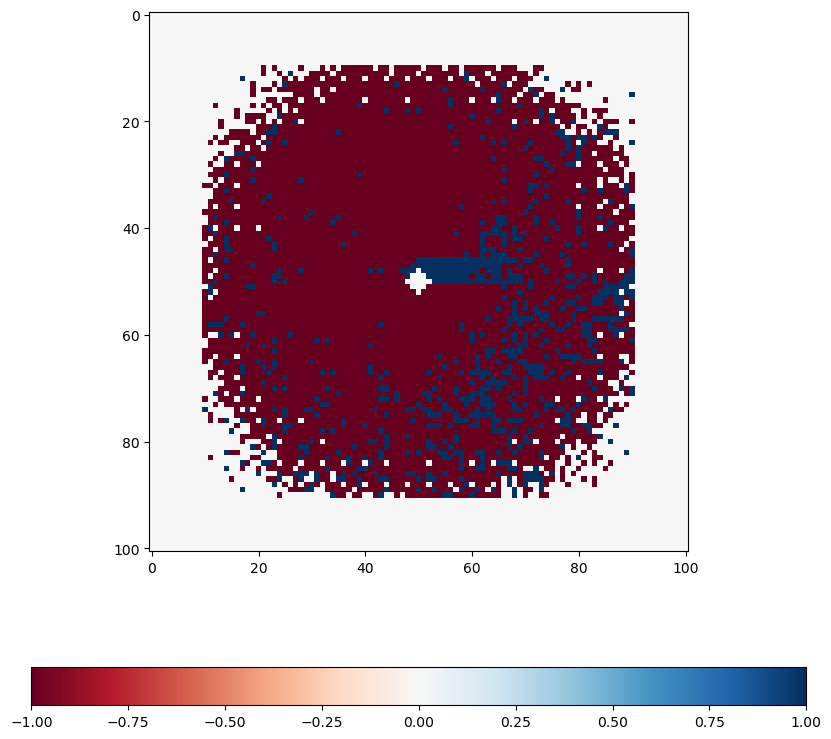

In [59]:
start_points_grid = np.zeros(env.shape)

failed_points = hist.start_points[hist.done_at_step == -1]
success_points = hist.start_points[hist.done_at_step != -1]

start_points_grid[failed_points[:,0], failed_points[:,1]] = -1
start_points_grid[success_points[:,0], success_points[:,1]] = 1

plt.figure(figsize=(10,10))
plt.imshow(start_points_grid, cmap='RdBu')
plt.colorbar(orientation='horizontal')

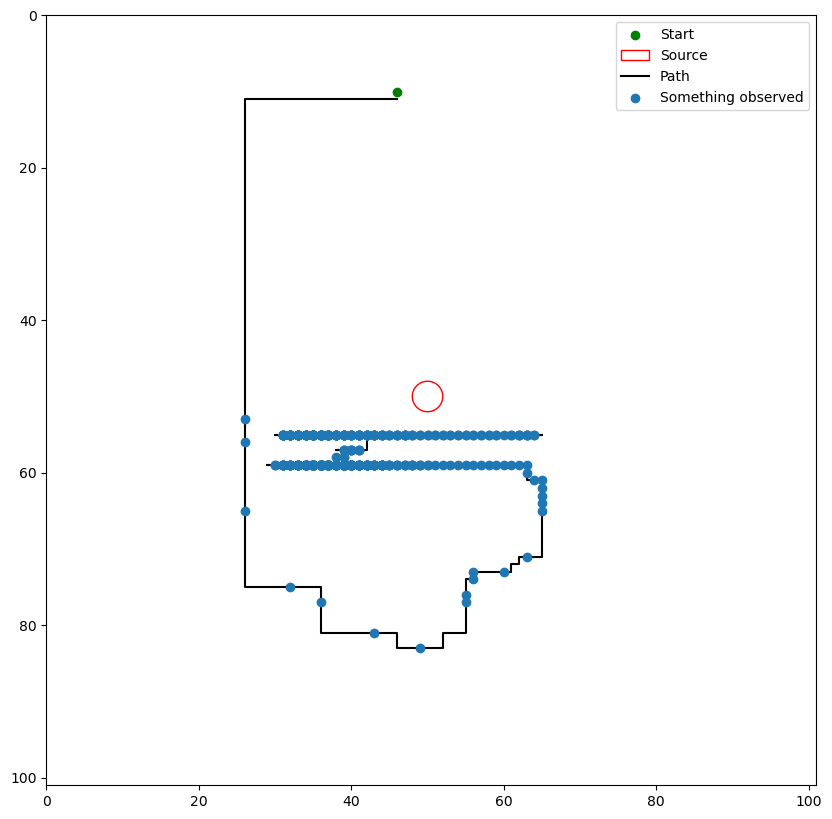

In [60]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(13, ax= ax)

In [62]:
hist.simulation_dfs[13][900:]

,time,y,x,dy,dx,o,done
900,900,55,35,0,1,0.75,0
901,901,55,36,0,1,0.625,0
902,902,55,37,0,1,0.375,0
903,903,55,36,0,-1,0.75,0
904,904,55,35,0,-1,0.25,0
...,...,...,...,...,...,...,...
996,996,55,39,0,-1,0.1875,0
997,997,55,38,0,-1,1.0,0
998,998,55,37,0,-1,0.25,0
999,999,55,36,0,-1,0.375,0
